We want to compute intra and inter network connectivty from covariance matrices, which should have been computed in `compare_maps.ipynb`

In [1]:
from init_nb import init_notebook
config = init_notebook()

from pathlib import Path
import itertools

import joblib
import pandas as pd
import numpy as np
import numpy.linalg as npl
import matplotlib.pyplot as plt
import seaborn as sns

from bold_dementia.connectivity import (
    reshape_pvalues,
    network_to_network_connectivity,
    block_block,
    plot_matrix,
    group_by_networks,
    groupby_blocks,
    group_groupby
)
from bold_dementia.connectivity.atlases import Atlas
from bold_dementia.connectivity.histograms import fast_hist
from bold_dementia.utils.iterables import unique, itersize, all_equal

ATLAS = "gillig-regions"
SOFT = False
matrices_path = Path(
    f"{config['connectivity_matrices']}/atlas-{ATLAS}_default"
)

In [2]:
AD_matrices = joblib.load(matrices_path / "AD.joblib")
control_matrices = joblib.load(matrices_path / "control.joblib")

n_AD = AD_matrices.shape[0]
n_controls = control_matrices.shape[0]

atlas = Atlas.from_name(ATLAS, soft=SOFT)
n_regions = len(atlas.labels)

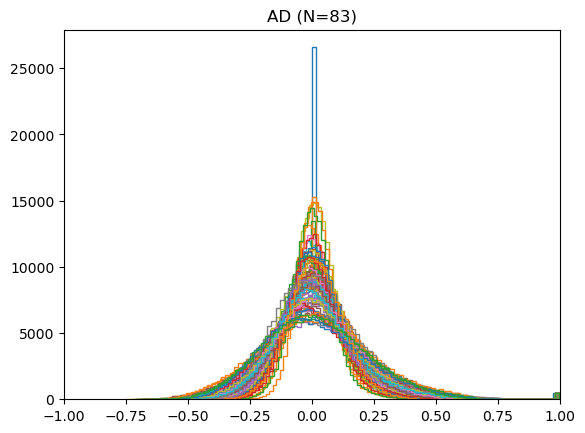

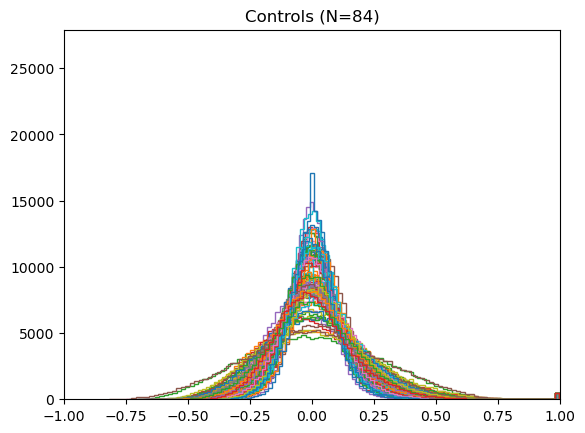

In [3]:
_, ax = fast_hist(AD_matrices, bins=100) 
ax.set_title(f"AD (N={n_AD})")
plt.show()

control_subsampled = control_matrices[::(n_controls//n_AD), :, :]
fig, ax2 = fast_hist(control_subsampled, bins=100) 
ax2.set_ylim(ax.get_ylim())
ax2.set_title(f"Controls (N={control_subsampled.shape[0]})")

plt.show()

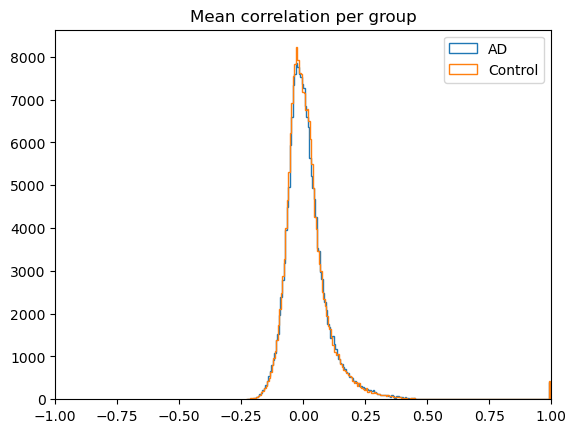

In [4]:
plt.hist(AD_matrices.mean(axis=0).flatten(), histtype="step", label="AD", bins=200)
plt.hist(control_matrices.mean(axis=0).flatten(), histtype="step", label="Control", bins=200)
plt.xlim(-1, 1)
plt.legend()
plt.title("Mean correlation per group")
plt.show()

In [5]:
ticks, sort_index = group_by_networks(atlas.macro_labels)

matrix_sort = np.ix_(sort_index, sort_index)
AD = AD_matrices.mean(axis=0)[matrix_sort]
control = control_matrices.mean(axis=0)[matrix_sort]


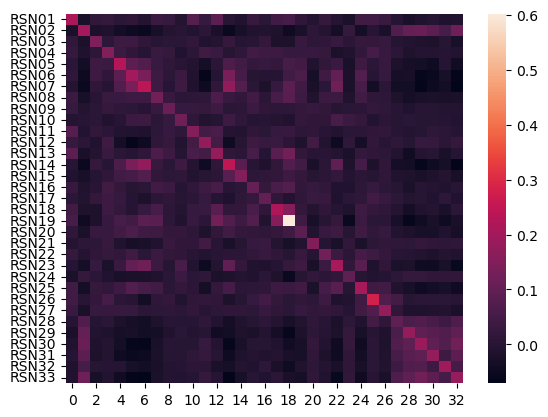

In [8]:
newAD, labels = group_groupby(AD_matrices, atlas)
sns.heatmap(newAD.mean(axis=0), yticklabels=labels)
plt.show()

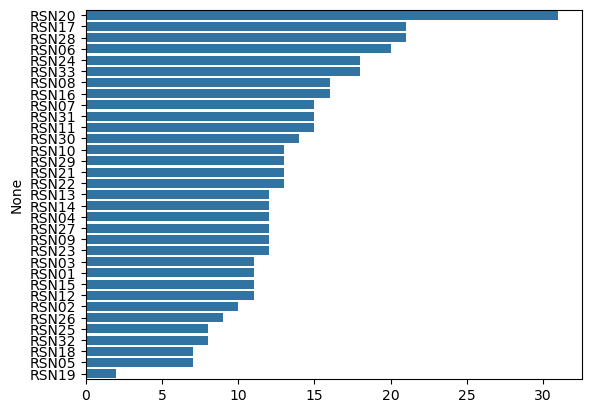

In [ ]:

names, counts = np.unique(np.array(atlas.macro_labels), return_counts=True)
s = pd.Series(dict(zip(tuple(names), tuple(counts)))).sort_values(ascending=False)
sns.barplot(y=s.index, x=s.values)
plt.show()


In [ ]:
unique_m = sorted(tuple(unique(atlas.macro_labels)))

network_to_idx = pd.Series(dict(zip(
    unique_m,
    itertools.pairwise(ticks)
)))
network_to_idx

RSN01       (0, 11)
RSN02      (11, 21)
RSN03      (21, 32)
RSN04      (32, 44)
RSN05      (44, 51)
RSN06      (51, 71)
RSN07      (71, 86)
RSN08     (86, 102)
RSN09    (102, 114)
RSN10    (114, 127)
RSN11    (127, 142)
RSN12    (142, 153)
RSN13    (153, 165)
RSN14    (165, 177)
RSN15    (177, 188)
RSN16    (188, 204)
RSN17    (204, 225)
RSN18    (225, 232)
RSN19    (232, 234)
RSN20    (234, 265)
RSN21    (265, 278)
RSN22    (278, 291)
RSN23    (291, 303)
RSN24    (303, 321)
RSN25    (321, 329)
RSN26    (329, 338)
RSN27    (338, 350)
RSN28    (350, 371)
RSN29    (371, 384)
RSN30    (384, 398)
RSN31    (398, 413)
RSN32    (413, 421)
RSN33    (421, 439)
dtype: object

In [ ]:
def mean_connectivity(block):
    return (np.mean(block),)


In [ ]:
df = pd.DataFrame(
    block_block(
        AD, network_to_idx, aggregating_func=mean_connectivity, 
    ),
        columns=["node_a", "node_b", "connectivity"]
)

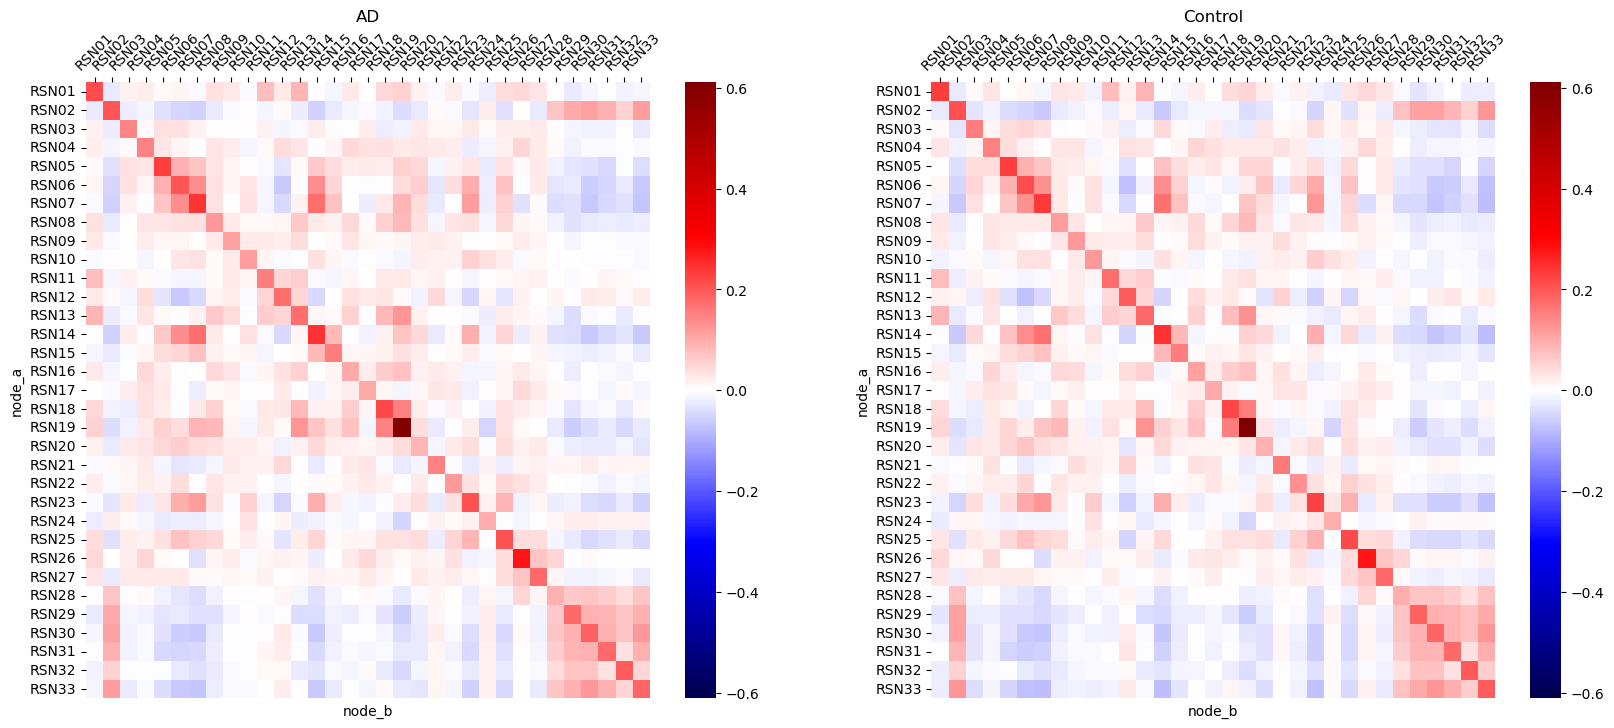

In [ ]:

from bold_dementia.connectivity.networks import macro_matrix


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

spanfunc = lambda arr: np.max(np.abs(arr))

macro_control = macro_matrix(control, network_to_idx)
macro_AD = macro_matrix(AD, network_to_idx)
span = max(spanfunc(macro_AD), spanfunc(macro_control))


heat_kwargs = {"vmin": -span, "vmax":span, "cmap":"seismic", "xticklabels":unique_m, "yticklabels":unique_m}

sns.heatmap(macro_AD, ax=ax1, **heat_kwargs)

sns.heatmap(macro_control, ax=ax2, **heat_kwargs)

ax1.tick_params(axis="x", labelrotation=45)
ax1.xaxis.tick_top()
ax1.set_title("AD")
ax2.tick_params(axis='x', labelrotation=45)
ax2.set_title("Control")
ax2.xaxis.tick_top()

plt.show()

Text(0.5, 1.0, 'gillig-regions AD - control')

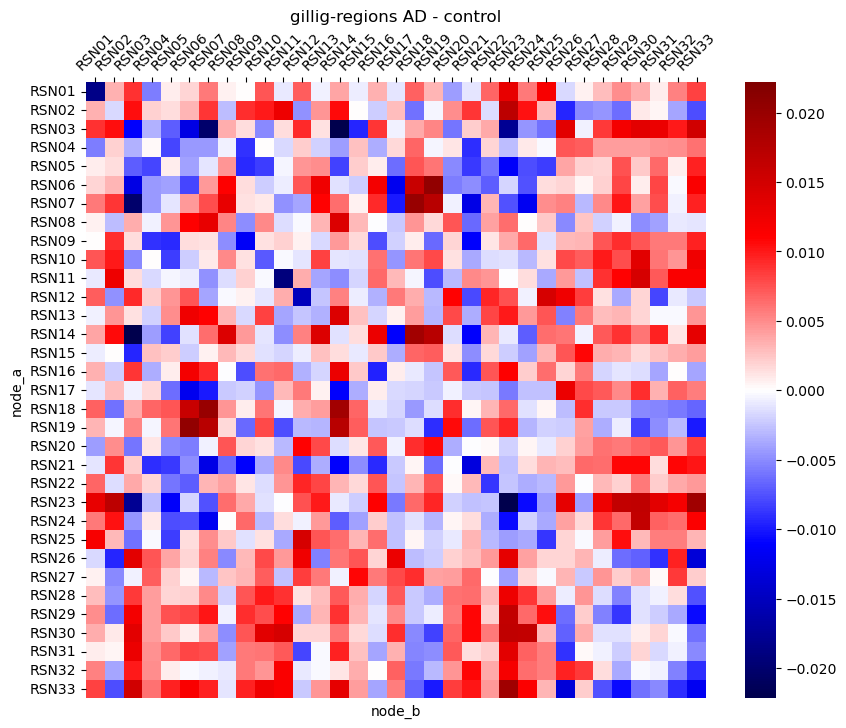

In [ ]:
diff = macro_AD - macro_control
dspan = np.max(abs(diff))

try:
    heat_kwargs.pop("vmin")
    heat_kwargs.pop("vmax")
except KeyError:
    pass

plt.subplots(1, 1, figsize=(10, 8))
ax = sns.heatmap(diff, vmin=-dspan, vmax=dspan, **heat_kwargs)
ax.xaxis.tick_top()
ax.tick_params(axis="x", labelrotation=45)
ax.set_title(f"{ATLAS} AD - control")